# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.12.0


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Train model

In [6]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.1183 - val_sparse_categorical_accuracy: 0.9624
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9744
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9762
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.0670 - val_sparse_categorical_accuracy: 0.9809
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0424 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.0676 - val_sparse_categorical_accuracy: 0.9796


In [7]:
test_img = test_images[:1]
prediction = model.predict(test_img)
prediction

1/1 [==============================] - 0s 55ms/step


array([[ -9.547884 ,  -4.7447677,  -0.956994 ,   1.0100659, -15.265252 ,
         -7.811299 , -15.518889 ,  14.113535 ,  -4.9397273,  -4.3322315]],
      dtype=float32)

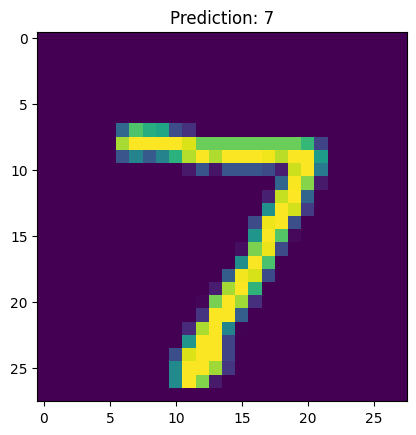

In [8]:
plt.figure()
plt.title("Prediction: {}".format(np.argmax(prediction)))
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [9]:
subprocess.call("rm -rf mnist_model".split())

0

In [10]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


INFO:tensorflow:Assets written to: mnist_model/assets


### Inspect saved model

In [11]:
subprocess.call("tree mnist_model".split())

mnist_model
├── assets
├── fingerprint.pb
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 5 files


0

In [12]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: serving_default_dense_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


0

### Load model

In [13]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [14]:
new_model.inputs

[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>]

### Predict

In [15]:
new_model.predict(test_images[:1])

1/1 [==============================] - 0s 30ms/step


array([[ -9.547884 ,  -4.7447677,  -0.956994 ,   1.0100659, -15.265252 ,
         -7.811299 , -15.518889 ,  14.113535 ,  -4.9397273,  -4.3322315]],
      dtype=float32)

## PySpark

In [16]:
import pandas as pd

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [17]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(10000, 784)

In [18]:
%%time
df = spark.createDataFrame(test_pdf)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min 2s


### Save as Parquet (784 columns of float)

In [19]:
%%time
df.write.mode("overwrite").parquet("mnist_784")

23/05/19 17:46:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/19 17:46:15 WARN TaskSetManager: Stage 0 contains a task of very large size (7067 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 5.72 s


### Save as Parquet (1 column of 784 float)

In [20]:
%%time
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 258 ms


(10000, 1)

In [21]:
%%time
df = spark.createDataFrame(pdf)

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.6 s


In [22]:
%%time
df.write.mode("overwrite").parquet("mnist_1")

23/05/19 17:46:33 WARN TaskSetManager: Stage 1 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 9.88 ms, sys: 0 ns, total: 9.88 ms
Wall time: 1.36 s


### Check arrow memory configuration

In [23]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

23/05/19 17:46:34 WARN TaskSetManager: Stage 2 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark DL API

### 1 column of 784 float

In [24]:
import numpy as np
import os
import pandas as pd

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [25]:
# get absolute path to model
model_dir = "{}/mnist_model".format(os.getcwd())

In [26]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [27]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [28]:
df = spark.read.parquet("mnist_1")
len(df.columns)

1

In [29]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [30]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 827 ms, sys: 0 ns, total: 827 ms
Wall time: 6.2 s


In [31]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 628 ms, sys: 0 ns, total: 628 ms
Wall time: 2.18 s


In [32]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 2.05 s


#### Check predictions

In [33]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.66701889038086, -3.6094393730163574, -3.31..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-16.348304748535156, 3.1133787631988525, 6.73..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-21.153539657592773, -6.192655086517334, -6.6..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-13.79001522064209, -16.20423126220703, -8.87..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-18.723485946655273, -7.806203365325928, -8.6..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.495272636413574, -10.992117881774902, -2.4..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.437854766845703, -3.7454347610473633, -3.5..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-12.314886093139648, -2.106672763824463, -0.7..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-22.142608642578125, -2.8917746543884277, -4...."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-12.939343452453613, 0.40699127316474915, 15...."


In [34]:
sample = preds.iloc[0]
sample.preds

[-9.66701889038086,
 -3.6094393730163574,
 -3.3102951049804688,
 -0.32629871368408203,
 -8.564104080200195,
 -3.614396095275879,
 -5.390956878662109,
 -3.0429909229278564,
 9.717466354370117,
 -5.417511463165283]

In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [36]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

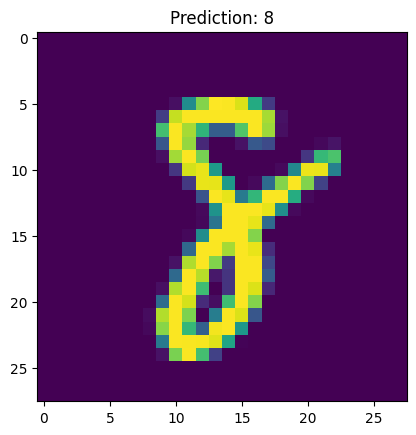

In [37]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [38]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [39]:
def predict_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [40]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [41]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [42]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

CPU times: user 971 ms, sys: 83 ms, total: 1.05 s
Wall time: 8.63 s


In [43]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 823 ms, sys: 136 ms, total: 959 ms
Wall time: 3.45 s


In [44]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [45]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-9.66701889038086, -3.6094393730163574, -3.31..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-16.348304748535156, 3.1133787631988525, 6.73..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-21.153539657592773, -6.192655086517334, -6.6..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-13.79001522064209, -16.20423126220703, -8.87..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-18.723485946655273, -7.806203365325928, -8.6..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[10.495272636413574, -10.992117881774902, -2.4..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-9.437854766845703, -3.7454347610473633, -3.5..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-12.314886093139648, -2.106672763824463, -0.7..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-22.142608642578125, -2.8917746543884277, -4...."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-12.939343452453613, 0.40699127316474915, 15...."


In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
sample = preds.iloc[0]
sample.preds

[-9.66701889038086,
 -3.6094393730163574,
 -3.3102951049804688,
 -0.32629871368408203,
 -8.564104080200195,
 -3.614396095275879,
 -5.390956878662109,
 -3.0429909229278564,
 9.717466354370117,
 -5.417511463165283]

In [48]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

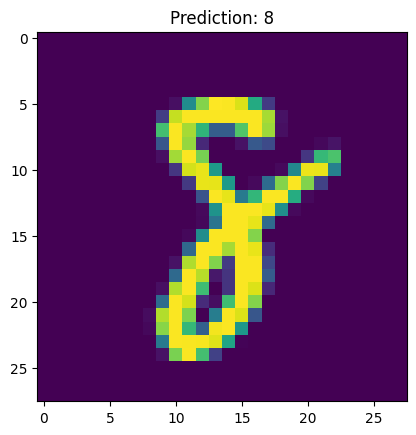

In [49]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [50]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [51]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/mnist_model/1
cp -r mnist_model models/mnist_model/1/model.savedmodel

# add config.pbtxt
cp models_config/mnist_model/config.pbtxt models/mnist_model/config.pbtxt

#### Start Triton Server on each executor

In [52]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:23.04-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

[True]

In [53]:
df = spark.read.parquet("mnist_1")
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

#### Using custom predict_batch_fn

In [54]:
def predict_batch_fn():
    import numpy as np
    import tritonclient.grpc as grpcclient
    client = grpcclient.InferenceServerClient("localhost:8001")
    def predict(inputs):
        request = [grpcclient.InferInput("dense_input", inputs.shape, "FP32")]
        request[0].set_data_from_numpy(inputs.astype(np.float32))
        response = client.infer("mnist_model", inputs=request)
        return response.as_numpy("dense_1")
    return predict

In [55]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=8192)

In [56]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 458 ms, sys: 80.5 ms, total: 538 ms
Wall time: 2.29 s


In [57]:
%%time
preds = df.withColumn("preds", mnist("data")).collect()

CPU times: user 455 ms, sys: 157 ms, total: 612 ms
Wall time: 1.31 s


In [58]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

CPU times: user 874 ms, sys: 68.9 ms, total: 943 ms
Wall time: 1.53 s


#### Check predictions

In [59]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.66701889038086, -3.6094400882720947, -3.31..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-16.348302841186523, 3.1133782863616943, 6.73..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-21.153541564941406, -6.192654132843018, -6.6..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-13.790016174316406, -16.204233169555664, -8...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-18.723485946655273, -7.8062005043029785, -8...."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.495272636413574, -10.992119789123535, -2.4..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.437854766845703, -3.745434284210205, -3.59..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-12.314884185791016, -2.106672525405884, -0.7..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-22.142610549926758, -2.891775369644165, -4.8..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-12.939340591430664, 0.40699198842048645, 15...."


In [60]:
import matplotlib.pyplot as plt
import numpy as np

In [61]:
sample = preds.iloc[0]
sample.preds

[-9.66701889038086,
 -3.6094400882720947,
 -3.310295581817627,
 -0.3262983560562134,
 -8.564104080200195,
 -3.614396095275879,
 -5.3909592628479,
 -3.0429911613464355,
 9.717466354370117,
 -5.417511940002441]

In [62]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

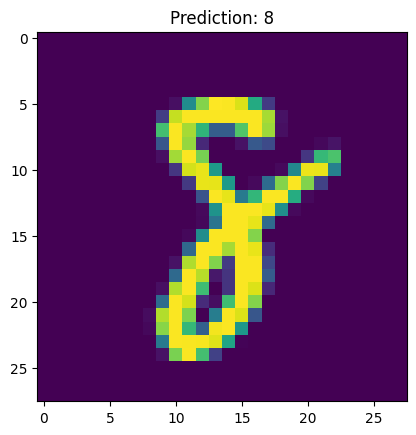

In [63]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Using generic Triton function

In [64]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient

    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)

    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))

        response = client.infer(model_name, inputs=request)

        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)

    return predict

In [65]:
from functools import partial

predict = predict_batch_udf(partial(triton_fn, "localhost:8001", "mnist_model"),
                            return_type=ArrayType(FloatType()),
                            input_tensor_shapes=[[784]],
                            batch_size=8192)

In [66]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 410 ms, sys: 104 ms, total: 514 ms
Wall time: 1.65 s


In [67]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 495 ms, sys: 81.4 ms, total: 576 ms
Wall time: 1.21 s


In [68]:
%%time
preds = df.withColumn("preds", predict(col("data"))).collect()

CPU times: user 858 ms, sys: 109 ms, total: 967 ms
Wall time: 1.58 s


#### Stop Triton Server on each executor

In [69]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

[True]

In [70]:
spark.stop()